In [66]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Read in Google date
df = pd.read_csv(r"C:\Users\hazze\OneDrive\Documents\DanceMad\dancemad_data_pipeline\process_data\google_data.csv", index_col=0)


In [67]:
# Look at head
df.head()


,name,formatted_address,rating,user_ratings_total,types,price_level,dance_type,city
0,Gonzalez y Gonzalez,"192 Mercer St, New York, NY 10012, United States",4.1,1820,"['restaurant', 'night_club', 'food', 'point_of...",2.0,Salsa,New York
1,Club Cache,"214 W 39th St, New York, NY 10018, United States",3.9,261,"['night_club', 'point_of_interest', 'establish...",NaN,Salsa,New York
2,Salsa Con Fuego,"2297 Cedar Ave, Bronx, NY 10468, United States",4.2,5711,"['bar', 'restaurant', 'food', 'point_of_intere...",2.0,Salsa,New York
3,Copacabana Nightclub,"625 W 51st St, New York, NY 10019, United States",3.5,631,"['night_club', 'point_of_interest', 'establish...",NaN,Salsa,New York
4,230 Fifth Rooftop Bar,"1150 Broadway, New York, NY 10001, United States",4.3,21498,"['night_club', 'bar', 'point_of_interest', 'es...",2.0,Salsa,New York


In [74]:
# Create city name mapping: city_name to shortform
def extract_capitals_or_first_three(input_string):
    # Extract capital letters from the string
    capital_letters = "".join([char for char in input_string if char.isupper()])
    
    # If there are fewer than three capital letters, take as many as there are, else take three
    if len(capital_letters) < 2:
        return input_string[:3]
    else:
        return capital_letters
    
city_sf = [extract_capitals_or_first_three(x) for x in df['city'].unique()]

city_mapping = dict(zip(df['city'].unique(), city_sf))

# Check mapping values is the same length as cities, to ensure no duplicates
assert len(set(city_mapping.values())) == len(df['city'].unique())

# Replace values
df['city'] = df['city'].replace(city_mapping)
city_mapping

{'New York': 'NY',
 'London': 'Lon',
 'Warsaw': 'War',
 'Madrid': 'Mad',
 'Barcelona': 'Bar',
 'Paris': 'Par',
 'Lima': 'Lim',
 'Rio de Janiero': 'RJ',
 'Cali, Colombia': 'CC',
 'Buenos Aires': 'BA'}

In [75]:
def bar(category, normal = True):
        """
        This function generates a bar plot for a given category from the Google data.

        Parameters:
        category (str): The column name from the Google data to be used for the bar plot.
            The column should contain categorical data.
        normal (bool): To decide whether to produca a normal bar chart, ot goruped bar plot

        Returns:
        None: The function generates a bar plot and does not return any value.
        """
        # Count the occurrences of each category
        category_counts = df[category].value_counts()

        # Plot the counts as a bar plot
        plt.figure(figsize=(10, 6))
        if normal:
            category_counts.plot(kind='bar')
        else:
            sns.countplot(data=df, x=category, hue='dance_type')

        # Add labels and title
        plt.xlabel(category)
        plt.ylabel('Count')
        plt.title(f"{category} count")
        plt.xticks(rotation=0)

        # Display the plot
        plt.show()



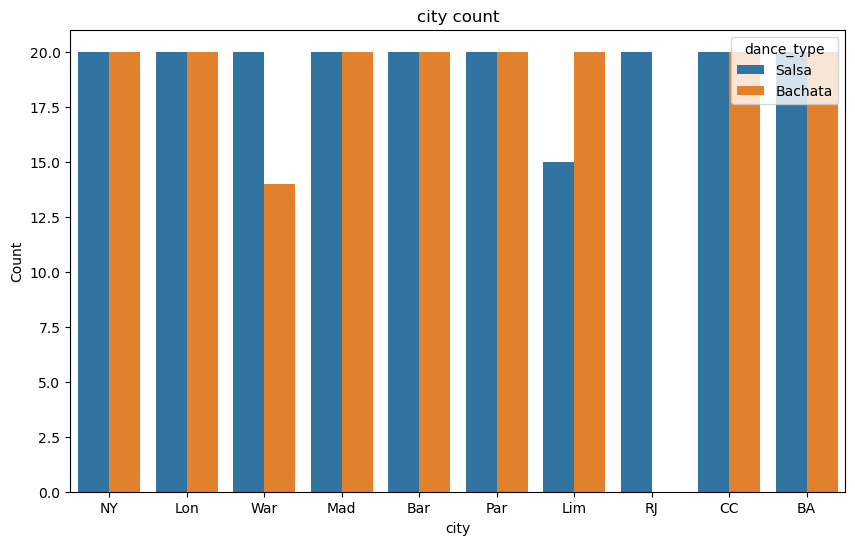

In [76]:
# Bar plot for each category
bar('city', normal = False)
# bar('dance_type')